<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Andrew/sources/stock_predictor_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

# Set plot stylizations

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

# Method for getting ticker data using Yahoo Finance API

This method downloads json data from the Yahoo! finance API and organizes it into a Pandas dataframe. The time frame of the data ends at the <font color='orange'>current</font> day and starts at a restricted time interval before the current day. Available time intervals are listed below

*Parameters:*

    ticker: Trading Ticker of equity
    constRange: String that specifies the time range of the dataset

*Returns:*

    df: Pandas dataframe with timestamp, open, high, low, close, and volume of a ticker

*   *Avaliable time ranges:*
  *   <font color='orange'>1d</font> - 1 Day
  *   <font color='orange'>5d</font> - 5 Days
  *   <font color='orange'>3mo</font> - 3 Months
  *   <font color='orange'>6mo</font> - 6 Months
  *   <font color='orange'>1y</font> - 1 Year
  *   <font color='orange'>2y</font> - 2 Years
  *   <font color='orange'>5y</font> - 5 Years
  *   <font color='orange'>10y</font> - 10 Years
  *   <font color='orange'>ytd</font> - From start of calendar year til now
  *   <font color='orange'>max</font> - All trading price data available for the ticker


In [3]:
def getStockData(ticker: str, constRange: str='5y'):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?region=US&lang=en-US&includePrePost=false&interval=1d&useYfid=true&range=" + constRange + "&corsDomain=finance.yahoo.com&.tsrc=finance"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    return df

def toDatetime(t):
    return datetime.fromtimestamp(t)


# Method for getting ticker data using Yahoo Finance API

This method downloads json data from the Yahoo! finance API and organizes it into a Pandas dataframe. The time frame of the data can start and end wherever the user wants it to. The start and end dates need to be a String in the form of a Unix Timestamp.

*Parameters:*

    ticker: String that specifies the trading ticker of the equity 
    startData: String that specifies the start time of the dataset. Formatted as a Unix Timestamp
    endData: String that specifies the start time of the dataset. Formatted as a Unix Timestamp

*Returns:*

    df: Pandas dataframe with timestamp, open, high, low, close, and volume of a ticker

In [4]:
def getStockDataInRange(ticker: str, startDate: str, endDate: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?period1=" + startDate + "&period2=" + endDate + "&useYfid=true&interval=1d&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=Yo9B6QaqJUD&corsDomain=finance.yahoo.com"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    return df

# Plotting QQQ open prices over the past 5 years to help visualize

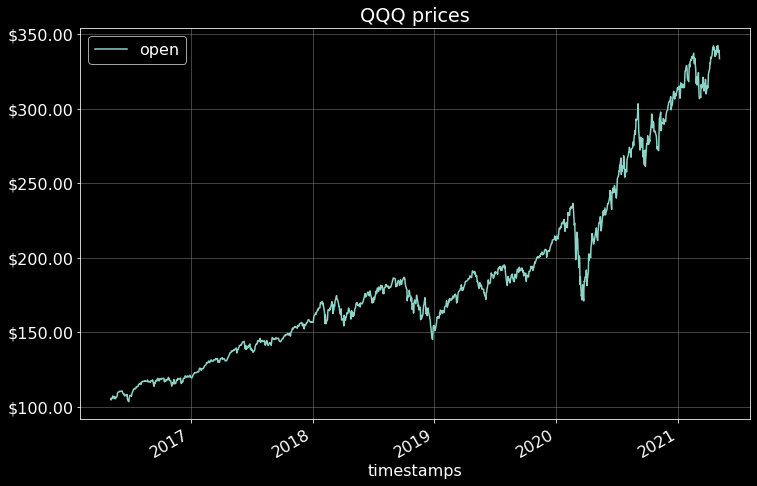

In [5]:
ticker = 'QQQ'
df = getStockData(ticker, constRange='5y')

ax = df.plot(x='timestamps', y=['open'], kind='line', title=ticker + ' prices')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

# Plotting QQQ open prices from January 1, 2009 to the current day using Unix Timestamps

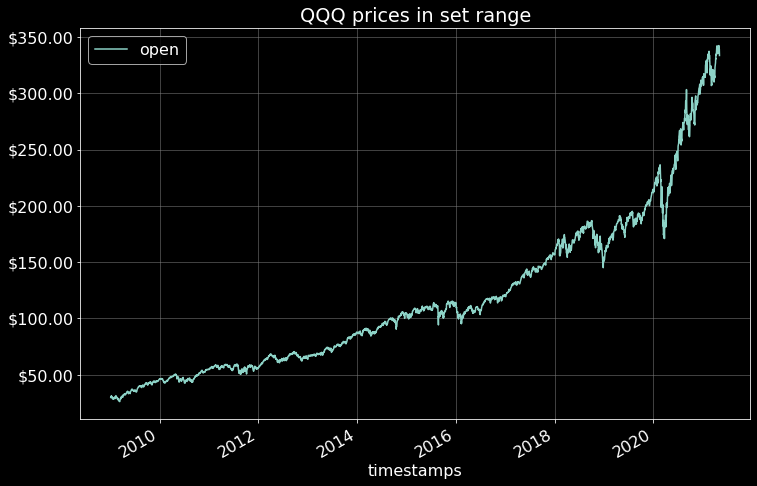

In [6]:
ticker = 'QQQ'
endDate = datetime.now().strftime('%s')
startDate = datetime(year=2009, month=1, day=1, hour=0, minute=0).strftime('%s')

range_df = getStockDataInRange(ticker=ticker, startDate=startDate, endDate=endDate)

ax = range_df.plot(x='timestamps', y=['open'], kind='line', title=ticker + ' prices in set range')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

# Method for labeling price data as BUY, HOLD, or SELL

This algorithm uses sliding window of 11 days on the stock price to determine when to Buy, Hold, or Sell. If the middle number is maximum within the window, label the middle day as ‘sell’ or, if the middle number is minimum then label the middle day as ‘buy’, else label as ‘hold’. The idea is to buy at troughs and sell at crests for any 11 day window.

*SELL = 0, BUY = 1, HOLD = 2*


*Parameters:*

    df: Pandas DataFrame
    col_name: Name of the column in df that will be used to determine labels
        - availiable names: "open", "close", "high", "low"
    window_size: How large the window size will be when determining labels
        - default size: 11

*Returns:*

    labels: Array of 0, 1, or 2 to indicate to the model when to sell, buy, or hold

In [7]:
from tqdm.auto import tqdm

def create_labels(df, col_name, window_size=11):

    row_counter = 0
    total_rows = len(df)
    # Creates a 1 x N numpy array
    labels = np.zeros(total_rows)
    # Makes all the entries in labels array equal to nan
    labels[:] = np.nan
    # Sets up a progress bar
    pbar = tqdm(total=total_rows)

    while row_counter < total_rows:

        # Stalls labeling calculation until the row_counter is at least as big as the window_size
        if row_counter >= window_size - 1:
            window_begin = row_counter - (window_size - 1)
            window_end = row_counter
            window_middle = (window_begin + window_end) // 2 # Cast as int

            min_ = np.inf
            min_index = -1
            max_ = -np.inf
            max_index = -1
            for i in range(window_begin, window_end + 1):
                # Selected value at 'i' index in column with name equal to col_name variable
                price = df.iloc[i][col_name]
                if price < min_:
                    # Finds the smallest value in the window
                    # 'min_' is initially set to infinity
                    min_ = price
                    # Saves the index of the lowest value
                    min_index = i
                if price > max_:
                    # Finds the largest value in the window
                    # 'max_' is initially set to -infinity
                    max_ = price
                    # Saves the index of the largest value
                    max_index = i

            if max_index == window_middle:
                # Sets label to SELL
                labels[window_middle] = 0
            elif min_index == window_middle:
                # Sets label to BUY
                labels[window_middle] = 1
            else:
                # Sets label to HOLD
                labels[window_middle] = 2

        row_counter = row_counter + 1
        pbar.update(1)

    pbar.close()
    return labels

# Plotting of prediction labels using 'close' column to visualize distribution across time frame

Text(0.5, 1.0, 'Prediction Labels')

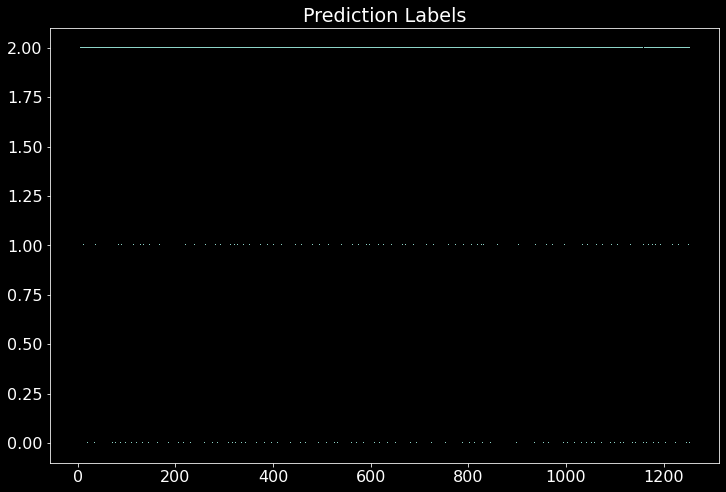

In [8]:
labels = create_labels(df, 'close')
df['labels'] = labels
df['labels'] = df['labels'].fillna(0)

fig = plt.figure()
plt.plot(labels, ',')
plt.title('Prediction Labels')

# Visualization of location of BUY markers for QQQ




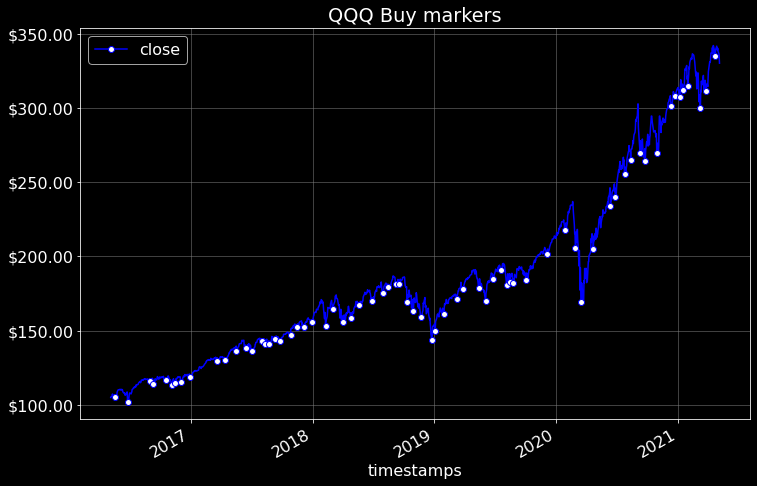

In [9]:
buy_markers = list(np.where(df['labels'] == 1)[0])

ax = df.plot(
    x='timestamps', 
    y=['close'], 
    kind='line', 
    color='b', 
    title=ticker + ' Buy markers', 
    markevery=buy_markers, 
    marker='o', 
    markerfacecolor='white')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

# Visualization of location of SELL markers for QQQ

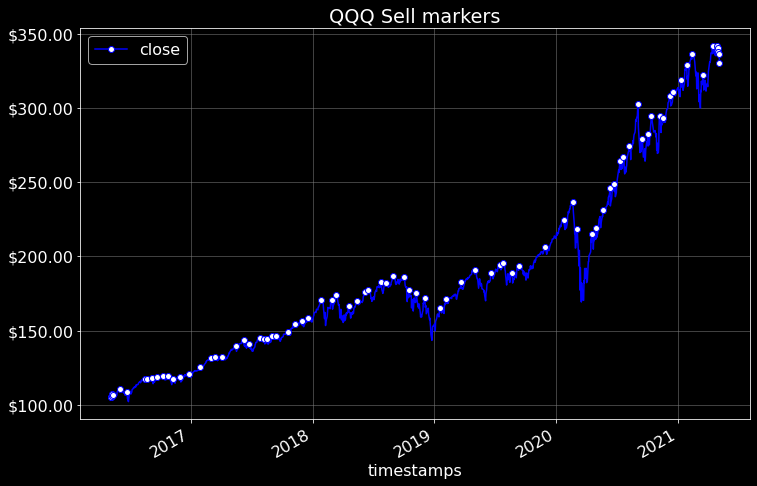

In [10]:
buy_markers = list(np.where(df['labels'] == 0)[0])

ax = df.plot(
    x='timestamps', 
    y=['close'], 
    kind='line', 
    color='b', 
    title=ticker + ' Sell markers', 
    markevery=buy_markers, 
    marker='o', 
    markerfacecolor='white')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

# Method Definition for plotting indicators

In [11]:
def plot_indicators(df, columns, yTitle, xTitle):
    plt.figure()
    ax = df[columns].plot(title=yTitle)
    ax.set_xlabel(xTitle)
    ax.set_ylabel(yTitle)

# Technical Indicator methods


***Technical Indicators Used:***

*   MACD
*   RSI
*   %K
*   %D
*   ATR
*   DEMA
*   BB
*   WR









# ***RSI***: Relative Strength Index



*   Signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset's price
*   An asset is usually considered overbought when the RSI is above ***`70%`*** and oversold when it is below ***`30%`***
*   A momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset
*   The RSI is displayed as an oscillator and can have a reading from 0 to 100.

$$\frac{sin(x)}{x}$$

\begin{equation}
F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx
\end{equation}

\begin{equation}
RSI_{step-one} = 100 - \Bigg[ \frac{100}{1 + \frac{Average Gain}{Average Loss}}\Bigg]
\end{equation}

\begin{equation}
RSI_{step-two} = 100 - \Bigg[ \frac{100}{1 + \frac{(Previous Average Gain*(N-1)) + Current Gain}{(Previous Average Loss*(N-1)) + Current Loss}}\Bigg]
\end{equation}

[Investopedia](https://www.investopedia.com/terms/r/rsi.asp)

<font color='red'> TODO: Code calculation might be slightly wrong </font>



In [12]:
def calculate_rsi(df, iteration):
    diff = df['close'].diff()
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0 # Converting to Average Gain
    down[down > 0] = 0 # Converting to Average Loss
    down = abs(down) # Positive Value of Average Loss
    iter_Num_Day_Up_Closes = up.rolling(iteration).mean() # interation # day periods
    iter_Num_Day_Down_Closes = down.rolling(iteration).mean() # interaction # day periods
    relative_strength = iter_Num_Day_Up_Closes / iter_Num_Day_Down_Closes
    df['RSI_'+str(iteration)] = 100 - (100 / (1 + relative_strength))
    df['RSI_'+str(iteration)] = df['RSI_'+str(iteration)].fillna(0)

# ***MACD***: Moving Average Convergance Diverage Momentum


* MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line.
* The speed of crossovers is also taken as a signal of a market is overbought or oversold.
* MACD helps investors understand whether the bullish or bearish movement in the price is strengthening or weakening.

\begin{equation}
MACD =  EMA_{12-period} - EMA_{26-period}
\end{equation}

[Investopedia](https://www.investopedia.com/terms/m/macd.asp)

In [13]:
def calculate_macd(df, iteration):
    df['MACD_'+str(iteration)] = df["close"].ewm(span=12).mean() - df["close"].ewm(span=26).mean()
    df['MACD_'+str(iteration)] = df['MACD_'+str(iteration)].fillna(0)
    #df['Signal Line'] = df['MACD'].ewm(span=9).mean()

# ***EMA***: Exponential Moving Average


*   Moving average that places a greater weight and significance on the most recent data points
*   Traders often use several different EMA lengths, such as <font color='orange'> 10-day </font>, <font color='orange'> 50-day </font>, and <font color='orange'> 200-day </font> moving averages.

\begin{equation}
EMA = \Bigg( Value_{Today}  * \Big( \frac{Smoothing}{1+Days} \Big) + EMA_{Yesterday} * \Big( 1 - \Big( \frac{Smoothing}{1+Days} \Big) \Big) \Bigg)
\end{equation}

\begin{equation}
Weighted Multipler = \frac{Smoothing}{1+Days}
\end{equation}

\begin{equation}
EMA = \Bigg( \Big( Value_{Today} - EMA_{Yesterday} \Big) * \Big( Weighted Multipler \Big) + EMA_{Yesterday} \Bigg)
\end{equation}

*   While there are many possible choices for the smoothing factor, the most common choice is:
  *   <font color='orange'> Smoothing = 2 </font>
  *   That gives the most recent observation more weight. If the smoothing factor is <font color='orange'> increased </font>, more recent observations have <font color='orange'> more influence </font> on the EMA.


[Investopedia Definition](https://www.investopedia.com/terms/e/ema.asp)

[Investopedia Calculation](https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp)



In [14]:
def calculate_ema(df, iteration, windowSize=11):

    if 'EMA_'+str(iteration) in df.columns:
        return df['EMA_'+str(iteration)]
        print("found EMA column")
    else:
        multiplier = (2/(windowSize+1))
        ema_1 = df['close'].rolling(windowSize).sum() / windowSize
        #ema_1 = ema_1.fillna(0)
        df['EMA_'+str(iteration)] = (df['close'] -  ema_1) * multiplier + ema_1 # -> Is this right?
        df['EMA_'+str(iteration)] = df['EMA_'+str(iteration)].fillna(0)
        return df['EMA_'+str(iteration)]

# ***SR***: Stochastic Oscillator



*   The general theory serving as the foundation for this indicator is that in a market trending upward, prices will close near the high, and in a market trending downward, prices close near the low
*   Transaction signals are created when the %K crosses through a three-period moving average, which is called the %D.

\begin{equation}
K = \Bigg( \frac{C - L14}{H14-L14} \Bigg) * 100
\end{equation}



*   where:
    *   <font color="orange">C</font> = The most recent closing price
    *   <font color="orange">L14</font> = The lowest price traded of the 14 previous
trading sessions
    *   <font color="orange">H14</font> = The highest price traded during the same 14-day period
    *   <font color="orange">%K</font> = The current value of the stochastic indicator

[Investopedia Definition](https://www.investopedia.com/terms/s/stochasticoscillator.asp)


In [15]:
# SR: Stochastic Oscillator
def calculate_sr(df, iteration):
    eleven_high = df['high'].rolling(11).max()
    eleven_low = df['low'].rolling(11).min()
    # %K is referred to sometimes as the fast stochastic indicator
    fast_K = (df['close']-eleven_low)*100/(eleven_high - eleven_low)
    # The "slow" stochastic indicator is taken as %D = 3-period moving average of %K
    df['%D_'+str(iteration)] = fast_K.rolling(3).mean()
    df['%D_'+str(iteration)] = df['%D_'+str(iteration)].fillna(0)

# ***WR***: Williams Percent Range



*   Williams %R moves between zero and -100.
*   A reading above -20 is overbought.
*   A reading below -80 is oversold.
*   An overbought or oversold reading <font color='red'>doesn't</font> mean the price will reverse. Overbought simply means the price is near the highs of its recent range, and oversold means the price is in the lower end of its recent range.

\begin{equation}
WR  = \Bigg( \frac{Highest High - Close}{Highest High - Lowest Low} \Bigg) * -100
\end{equation}



*   where:
  *   <font color='orange'>Highest High</font> = Highest price in the lookback
period, typically 14 days.
  *   <font color='orange'>Lowest Low</font> = Lowest price in the lookback period, typically 14 days.
  *   <font color='orange'>Close</font> = Most recent closing price


The Williams %R (<font color='green'>***WR***</font>) and the Fast Stochastic Oscillator (<font color='green'>***SR***</font>) end up being <font color='red'>almost the exact same</font> indicator. The only difference between the two is how the indicators are scaled. 

[Investopedia Definition](https://www.investopedia.com/terms/w/williamsr.asp)


In [16]:
def calculate_WR(df, iteration):
    eleven_high = df['high'].rolling(11).max()
    eleven_low = df['low'].rolling(11).min()
    df['WR_'+str(iteration)] = (eleven_high - df['close']) / (eleven_high - eleven_low) * -100
    df['WR_'+str(iteration)] = df['WR_'+str(iteration)].rolling(3).mean()
    df['WR_'+str(iteration)] = df['WR_'+str(iteration)].fillna(0)

# ***MFI***: Money Flow Index

*   Uses price and volume data for identifying overbought or oversold signals in an asset
*   It can also be used to spot divergences which warn of a trend change in price.
*   The oscillator moves between <font color='orange'>0</font> and <font color='orange'>100</font>.
*   An MFI reading above <font color='orange'>80</font> is considered <font color='orange'>overbought</font> and an MFI reading below <font color='orange'>20</font> is considered <font color='orange'>oversold</font>, although levels of 90 and 10 are also used as thresholds


\begin{equation}
MFI  = \Bigg( 100 - \frac{100}{1 + Money ~Flow ~Ratio} \Bigg)
\end{equation}



*   where:

\begin{equation}
Money ~Flow ~Ratio  = \Bigg(\frac{14~Period ~Positive ~Money ~Flow}{14~Period ~Negative ~Money ~Flow} \Bigg)
\end{equation}

\begin{equation}
Raw ~Money ~Flow  = Typical ~Price * Volume
\end{equation}

\begin{equation}
Typical ~Price  = \Bigg(\frac{High+Low+Close}{3} \Bigg)
\end{equation}



*   When the price advances from one period to the next Raw Money Flow is <font color='lightgreen'>**positive**</font> and it is added to Positive Money Flow. 
*   When Raw Money Flow is <font color='red'>**negative**</font> because the price dropped that period, it is added to Negative Money Flow.




[Investopedia Definition](https://www.investopedia.com/terms/m/mfi.asp)


<font color='red'>TODO: Check that code calculations are correct</font>

In [17]:
# MFI: Money Flow Index
def calculate_mfi(df, iteration):
    price = (df['close'] + df['high'] + df['low']) / 3
    #mf = df['tp'] * df['volume']
    mf = price * df['volume']
    positive_flow = []
    negative_flow = []
    positive_mf = []
    negative_mf = []
    # Loop through typical price calculations
    for i in range(1, len(price)):
        # If current TP > previous TP, mark as positive flow
        if price[i] > price[i-1]:
            positive_flow.append(mf[i-1])
            negative_flow.append(0)
        # If current TP < previous TP, mark as negative flow
        elif price[i] < [i-1]:
            negative_flow.append(mf[i-1])
            positive_flow.append(0)
        # If no change, mark both as zero
        else:
            positive_flow.append(0)
            negative_flow.append(0) 
    for i in range(len(positive_flow) + 1):
        positive_mf.append(sum(positive_flow[i+1-11:i+1]))
    for i in range(len(negative_flow) + 1):
        negative_mf.append(sum(negative_flow[i+1-11:i+1]))
    df['MFI_'+str(iteration)] = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
    #df['MFI_'+str(iteration)] = 100 - (100 / (1 + (np.array(positive_mf) + np.array(negative_mf))))
    df['MFI_'+str(iteration)] = df['MFI_'+str(iteration)].fillna(0)

# ***BB***: Bollinger Band



*   When the bands come close together, constricting the moving average, it is called a squeeze.
*   The <font color='red'>mistake</font> most people make is believing that that price hitting or exceeding one of the bands is a signal to buy or sell. 
*   Breakouts provide <font color='red'>no clue</font> as to the direction and extent of future price movement.
*   The upper and lower bands are typically <font color='orange'>2 standard deviations +/-</font> from a 20-day simple moving average, but can be modified.

\begin{equation}
BOLU  = MA(TP, n) + m * σ[TP, n]
\end{equation}

\begin{equation}
BOLD  = MA(TP, n) - m * σ[TP, n]
\end{equation}



*   where:
  *   <font color='orange'>BOLU</font> = Upper Bollinger Band
  *   <font color='orange'>BOLD</font> = Lower Bollinger Band
  *   <font color='orange'>MA</font> = Moving average
  *   <font color='orange'>TP</font> (typical price) = (High + Low + Close) ÷ 3
  *   <font color='orange'>n</font> = Number of days in smoothing period (typically 20)
  *   <font color='orange'>m</font> = Number of standard deviations (typically 2)
  *   <font color='orange'>σ[TP,n]</font> = Standard Deviation over last n periods of TP



In [18]:
def calculate_bb(df, iteration):
    # Creating temporary Dataframe
    atr_df = pd.DataFrame()
    atr_df['close'] = df['close']
    atr_df['MA11'] = df['close'].rolling(window=11).mean()
    atr_df['11STD'] = df['close'].rolling(window=11).std()
    atr_df['Upper'] = atr_df['MA11'] + (atr_df['11STD'] * 2) # -> Where is this 2 coming from?
    atr_df['Lower'] = atr_df['MA11'] - (atr_df['11STD'] * 2)
    df['BB_'+str(iteration)] = atr_df[['close','MA11','Upper','Lower']].max(axis=1)
    df['BB_'+str(iteration)] = df['BB_'+str(iteration)].fillna(0)
    #plot_indicators(atr_df, ['Upper', 'Lower', 'MA11'], "Bollinger Band", "Days")

    lower = atr_df['Lower'].to_numpy()
    upper = atr_df['Upper'].to_numpy()
    ma = atr_df['MA11'].to_numpy()
    x = np.arange(lower.shape[0])

    fig, (ax1) = plt.subplots(1, 1, sharex=True)

    ax1.fill_between(x, lower, upper, alpha=0.25, color='lime', label='Upper and Lower Bands')
    ax1.plot(x, ma, color='white', label='11 day moving average')
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
    ax1.legend(loc='upper right')
    ax1.grid(linestyle='-', linewidth='0.5', color='gray')
    ax1.yaxis.grid(True)
    ax1.set_ylabel('Current Price')
    ax1.set_xlabel('Number of Days')
    ax1.set_title('Bollinger Band of ' + ticker)







# ***ATR***: Average True Range



*   A market volatility indicator used in technical analysis
*   It is typically derived from the <font color='orange'>14-day</font> simple moving average of a series of true range indicators


\begin{equation}
TR  = Max \Big[ (H-L), ~Abs(H-C_{p}), ~Abs(L-C_{p}) \Big]
\end{equation}
\begin{equation}
ATR  = \Big( \frac{1}{n} \Big) \sum_{i=1}^{n}{TR_{i}}
\end{equation}

*   where:
  *   <font color='orange'>$TR_{i}$</font> = A particular true range
  *   <font color='orange'>n</font> = The time period employed
  *   <font color='orange'>$C_{p}$</font> = Previous Close
  *   <font color='orange'>H</font> = Current High
  *   <font color='orange'>L</font> = Current Low



*   Traders can use <font color='orange'>shorter periods</font> than 14 days to generate more trading signals, while <font color='orange'>longer periods</font> have a higher probability to generate fewer trading signals.
*   List item


[Investopia Definition](https://www.investopedia.com/terms/a/atr.asp)




In [19]:
# ATR: Average True Range
def calculate_atr(df, iteration):
    # Checks to see if iteration is already in the dataframe
    if 'ATR_'+str(iteration) in df.columns:
        return df['ATR_'+str(iteration)]
    else:
        data = df.copy()
        high = df['high']
        low = df['low']
        close = df['close']
        tr_0 = abs(high - low)
        # Creating temporary Dataframe
        atr_df = pd.DataFrame()
        atr_df['tr0'] = abs(high - low)
        atr_df['tr1'] = abs(high - close.shift())
        atr_df['tr2'] = abs(low - close.shift())
        atr_df['TR'] = atr_df[['tr0', 'tr1', 'tr2']].max(axis=1)
        df['ATR_'+str(iteration)] = atr_df['TR'].ewm(alpha=1/11,adjust=False).mean()
        df['ATR_'+str(iteration)] = df['ATR_'+str(iteration)].fillna(0)
        #print(np.where(df['ATR'] < 0))
        return df['ATR_'+str(iteration)]

# ***KC***: Kelter Channel



*   The exponential moving average (EMA) of a Keltner Channel is typically <font color='orange'>20 periods</font>, although this can be adjusted if desired.
*   The upper and lower bands are typically set <font color='orange'>two times</font> the average true range (ATR) above and below the EMA, although the multiplier can also be adjusted based on personal preference.
*   Price reaching the upper Keltner Channel band is <font color='lightgreen'>bullish</font>, while reaching the lower band is <font color='red'>bearish</font>.
*   The angle of the Keltner Channel also aids in identifying the trend direction.

\begin{equation}
Keltner ~Channel ~Middle ~Line = EMA
\end{equation}
\begin{equation}
Keltner ~Channel ~Upper ~Line = EMA + 2 * ATR
\end{equation}
\begin{equation}
Keltner ~Channel ~Lower ~Line = EMA - 2 * ATR
\end{equation}



*   where:
  *   <font color='orange'>EMA</font> = Exponential moving average (typically over <font color='orange'>20</font> periods)
  *   <font color='orange'>ATR</font> = Average True Range (typically over <font color='orange'>10 or 20</font> periods)
*   The bands may also not act as support or resistance and they may seem to have little forecasting ability at all. This could be due to the settings chosen, but there is also <font color='red'>no evidence</font> that the price moving two ATRs or hitting one of the bands will result in a trading opportunity or something significant happening.


[Investopedia](https://www.investopedia.com/terms/k/keltnerchannel.asp)




In [20]:
# KC: Kelter Channel
def calculate_kc(df, iteration):
    #df['KC'] = df.copy
    #KelChM = pd.Series(((df['high'] + df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChM_' + str(11)) 
    #KelChU = pd.Series(((4 * df['high'] - 2 * df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChU_' + str(11))  
    #KelChD = pd.Series(((-2 * df['high'] + 4 * df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChD_' + str(11))
    atr = calculate_atr(df, iteration)
    temp_df = pd.DataFrame()
    temp_df['middle'] = calculate_ema(df, iteration)
    temp_df['upper'] = temp_df['middle'] + 2 * atr
    temp_df['lower'] = temp_df['middle'] - 2 * atr
    df['KC_'+str(iteration)] = temp_df[['middle','upper','lower']].max(axis=1)
    df['KC_'+str(iteration)] = df['KC_'+str(iteration)].fillna(0)
    #print(np.where(temp_df['middle'] > temp_df['upper']))

# ***DEMA***: Double Exponential Moving Average



*   The Double Exponential Moving Average (DEMA) is one that <font color='orange'>responds more quickly</font> to near-term price changes than a normal exponential moving average (EMA)
*   The DEMA can be used in the same way as other MAs, as long as the trader understands the indicator will <font color='orange'>react quicker and contain less information</font> since it's been smoothed twice. This may require some alteration of strategies.
*   Less lag is <font color='red'>not always</font> a good thing because lag helps <font color='orange'>filter out noise</font>. An indicator with less lag is more prone to reacting to noise or small inconsequential price moves.
*   A longer-term time frame DEMA, e.g. over 100 periods, will be slower to react than a shorter-term time frame DEMA, of e.g. 20 periods.



\begin{equation}
DEMA = 2 * EMA_{N} - EMA ~of ~EMA_{N}
\end{equation}



*   where
  *   <font color='orange'>N</font> = Look-back period

[Investopedia Definition](https://www.investopedia.com/terms/d/double-exponential-moving-average.asp)





In [21]:
# DEMA: Double Exponential Moving Average
def calculate_dema(df, iteration):
    multiplier = (2/(11+1))
    dema_1 = sum(df['close'],11)
    df['DEMA_'+str(iteration)] = (df['close'] * multiplier) + (dema_1 * (1-multiplier))
    df['DEMA_'+str(iteration)] = df['DEMA_'+str(iteration)].fillna(0)

# ***CCI***: Commodity Channel Index



*   The Commodity Channel Index (CCI) is a technical indicator that measures the difference between the current price and the historical average price.
*   When the CCI is above zero, it indicates the price is above the historic average. Conversely, when the CCI is below zero, the price is below the historic average.
*   The CCI is an unbounded oscillator, meaning it can go higher or lower indefinitely. For this reason, overbought and oversold levels are typically determined for each individual asset by looking at historical extreme CCI levels where the price reversed from.
*   When the CCI moves from negative or near-zero territory to <font color='orange'>above 100</font>, that may indicate the price is starting a new uptrend. Once this occurs, traders can watch for a pullback in price followed by a rally in both price and the CCI to signal a <font color='orange'>buying</font> opportunity.
*   The same concept applies to an emerging downtrend. When the indicator goes from positive or near-zero readings to <font color='orange'>below -100</font>, then a downtrend may be starting. This is a signal to get out of longs or to start watching for <font color='orange'>shorting</font> opportunities.

\begin{equation}
DEMA = \frac{Typical ~Price - MA}{0.015 * Mean ~Deviation}
\end{equation}

*   where:
  *   <font color='orange'>Typical Price</font> = $\sum_{i=1}^{P}{\Big(\frac{High + Low + Close}{3}\Big)}$
  *   <font color='orange'>P</font> = Number of periods
  *   <font color='orange'>MA</font> = Moving Average
  *   <font color='orange'>Moving Average</font> = $\frac{\Big(\sum_{i=1}^{P}{Typical Price}\Big)}{P}$
  *   <font color='orange'>Mean Deviation</font> = $\frac{\Big(\sum_{i=1}^{P}{|Typical ~Price - MA|}\Big)}{P}$

[Investopedia Definition](https://www.investopedia.com/terms/c/commoditychannelindex.asp)





In [22]:
# CCI: Commodity Channel Index
def calculate_cci(df, iteration):
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    df['CCI_'+str(iteration)] = ((typical_price - typical_price.rolling(11).mean())/ (0.015 * typical_price.rolling(11).std()))
    df['CCI_'+str(iteration)] = df['CCI_'+str(iteration)].fillna(0)

# ***EMV***: Ease of Movement Volume



*   This indicator calculates how easily a price can move up or down.
*   The calculation subtracts yesterday's average price from today's average price and divides the difference by volume.
*   This generates a volume-weighted momentum indicator.

\begin{equation}
Distance ~Moved = \Bigg(\frac{High + Low}{2} - \frac{PH + PL}{2}\Bigg)
\end{equation}

\begin{equation}
Box ~Ratio = \frac{\big(\frac{Volume}{Scale}\big)}{High + Low}
\end{equation}

\begin{equation}
1-Period ~EMV = \frac{Distance ~ Moved}{Box ~ Ratio}
\end{equation}

*   where
  *   <font color='orange'>PH</font> = Prior High
  *   <font color='orange'>PL</font> = Prior Low



*   Scale equals <font color='orange'>1,000</font> to <font color='orange'>1,000,000,000</font> depending on the average daily volume of the stock
  *   The more heavily traded the stock, the higher the scale should be to keep the indicator value in single or double digits.
*   When the indicator creates output values above zero and rising, this suggests that the price is <font color='lightgreen'><b>increasing</b></font> on low volume, while falling negative values suggest that the price is <font color='red'><b>dropping</b></font> on low volume.
*   Some analysts prefer to add a moving average to the EMV line and use it as a <font color='orange'>trigger line</font> to generate trading signals.

[Investopedia Definition](https://www.investopedia.com/terms/e/easeofmovement.asp)






In [23]:
def calculate_emv(df, iteration):
    distance_moved = ((df['high'] + df['low'])/2) - ((df['high'].shift(iteration) + df['low'].shift(iteration))/2)
    box_ratio = (df['volume'] / 100000000) / ((df['high'] - df['low']))
    df['EVM_'+str(iteration)] = distance_moved / box_ratio 
    df['EVM_'+str(iteration)] = df['EVM_'+str(iteration)].fillna(0)

# ***FI***: Force Index



*   A rising force index, above zero, helps confirm rising prices.
*   A falling force index, below zero, helps confirm falling prices.
*   A breakout, or a spike, in the force index, helps confirm a <font color='lightgreen'>breakout in price</font>.
*   If the force index is making lower swing highs while the price is making higher swing highs, this is bearish divergence and warns the <font color='red'>price may soon decline</font>.
*   If the force index is making higher swing lows while the price is making lower swing lows, this is bullish divergence and warns the <font color='lightgreen'>price may soon head higher</font>.
*   The force index is typically <font color='orange'>13 periods</font> but this can be adjusted based on preference. The more periods used the smoother the movements of the index, typically preferred by longer-term traders.

\begin{equation}
FI(1) = (CCP − PCP)∗VFI(13)
\end{equation}

\begin{equation}
13~Period~EMA~of~FI(1)
\end{equation}



*   where
  *   <font color='orange'>FI</font> = Force Index
  *   <font color='orange'>CCP</font> = Current close price
  *   <font color='orange'>PCP</font> = Prior close price
  *   <font color='orange'>VFI</font> Volume force index
  *   <font color='orange'>EMA</font> = Exponential moving average

[Investopedia Definition](https://www.investopedia.com/terms/f/force-index.asp)

 <font color='red'>TODO: Formula for VFI & EMA</font>


In [24]:
def calculate_fi(df, iteration):
    df['FI_'+str(iteration)] = df['close'].diff(iteration) * df['volume']
    df['FI_'+str(iteration)] = df['FI_'+str(iteration)].fillna(0)

# ***ROC***: Price Rate of Change



*   The Price Rate of Change (ROC) oscillator is and unbounded momentum indicator used in technical analysis set against a <font color='orange'>zero-level midpoint</font>.
*   A rising ROC above zero typically confirms an <font color='lightgreen'>uptrend</font> while a falling ROC below zero indicates a <font color='red'>downtrend</font>.
*   When the price is consolidating, the ROC will hover near zero. In this case, it is important traders <font color='orange'>watch the overall price trend</font> since the ROC will provide little insight except for confirming the consolidation.

\begin{equation}
ROC = \Bigg( \frac{Closing~Price_{p} - Closing~Price_{p-n}}{Closing~Price_{p-n}} \Bigg) * 100
\end{equation}



*   where
  *   <font color='orange'>$Closing~Price_{p}$</font> = Closing price of most recent price
  *   <font color='orange'>$Closing~Price_{p-n}$</font> = Closing price <font color='orange'>n</font> periods before


[Investopedia Definition](https://www.investopedia.com/terms/p/pricerateofchange.asp)



In [25]:
def calculate_roc(df, iteration):
    N = df['close'].diff(iteration)
    D = df['close'].shift(iteration)
    df['ROC_'+str(iteration)] = N / D
    df['ROC_'+str(iteration)] = df['ROC_'+str(iteration)].fillna(0)

# ***OBV***: On-Balance Volume



*   On-balance volume (OBV) is a technical indicator of momentum, using volume changes to make price predictions.
*   OBV shows crowd sentiment that can predict a <font color='lightgreen'>bullish</font> or <font color='red'>bearish</font> outcome.
*   Comparing relative action between price bars and OBV generates more actionable signals than the green or red volume histograms commonly found at the bottom of price charts. 


\begin{equation}
  OBV = OBV_{prev} +
  \begin{cases}
    volume,& \text{if} ~close>close_{prev}\\
    0,& \text{if} ~close=close_{prev}\\
    -volume,& \text{if} ~close<close_{prev}
  \end{cases}
\end{equation}



*   where
  *   <font color='orange'>OBV</font> = Current on-balance volume level
  *   <font color='orange'>$OBV_{prev}$</font> = Previous on-balance volume level
  *   <font color='orange'>volume</font> = Latest trading volume amount

[Investopedia Definition](https://www.investopedia.com/terms/o/onbalancevolume.asp)


In [26]:
def calculate_obv(df, iteration):
    df['OBV_'+str(iteration)] = np.where(df['close'] > df['close'].shift(1), df['volume'], np.where(df['close'] < df['close'].shift(1), -df['volume'],0)).cumsum()
    df['OBV_'+str(iteration)] = df['OBV_'+str(iteration)].fillna(0)

# Run all Technical Indicator methods

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


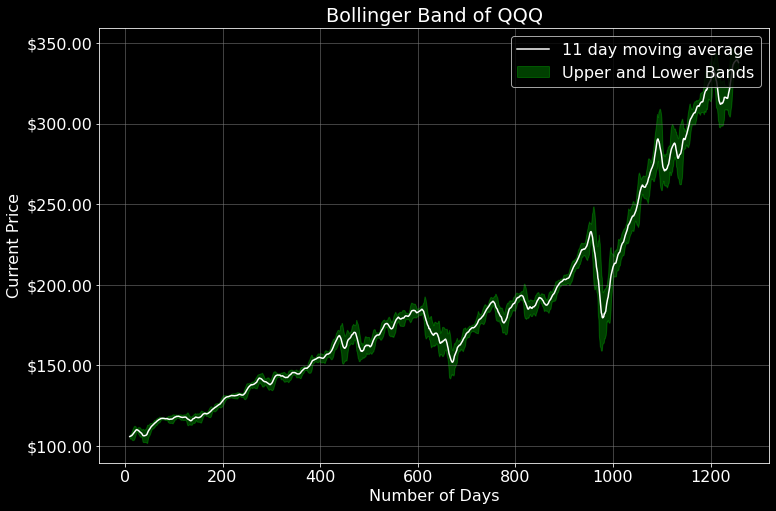

In [27]:
indicator_range = 26

# for x in range(1, indicator_range+1):
#     calculate_macd(df, x)
#     calculate_rsi(df, x)
#     calculate_sr(df, x)
#     calculate_WR(df, x)
#     calculate_ema(df, x)
#     calculate_mfi(df, x)
#     calculate_bb(df, x)
#     calculate_atr(df, x)
#     calculate_kc(df, x)
#     calculate_dema(df, x)
#     calculate_cci(df, x)
#     calculate_emv(df, x)
#     calculate_fi(df, x)
#     calculate_roc(df, x)
#     calculate_obv(df, x)

for x in range(1, indicator_range+1):
    calculate_macd(df, x)
for x in range(6, indicator_range+1):
    calculate_rsi(df, x)
for x in range(1, indicator_range+1):
    calculate_sr(df, x)
for x in range(1, indicator_range+1):
    calculate_WR(df, x)
for x in range(1, indicator_range+1):
    calculate_ema(df, x)
for x in range(1, indicator_range+1):
    calculate_mfi(df, x)
for x in range(1, 2):
    calculate_bb(df, x)
for x in range(1, indicator_range+1):
    calculate_atr(df, x)
for x in range(1, indicator_range+1):
    calculate_kc(df, x)
for x in range(1, indicator_range+1):
    calculate_dema(df, x)
for x in range(1, indicator_range+1):
    calculate_cci(df, x)
for x in range(1, 7):
    calculate_emv(df, x)
for x in range(10, indicator_range+1):
    calculate_fi(df, x)
for x in range(5, indicator_range):
    calculate_roc(df, x)
for x in range(1, indicator_range+1):
    calculate_obv(df, x)

#df.head(10)

# Plot charts for Technical Indicators

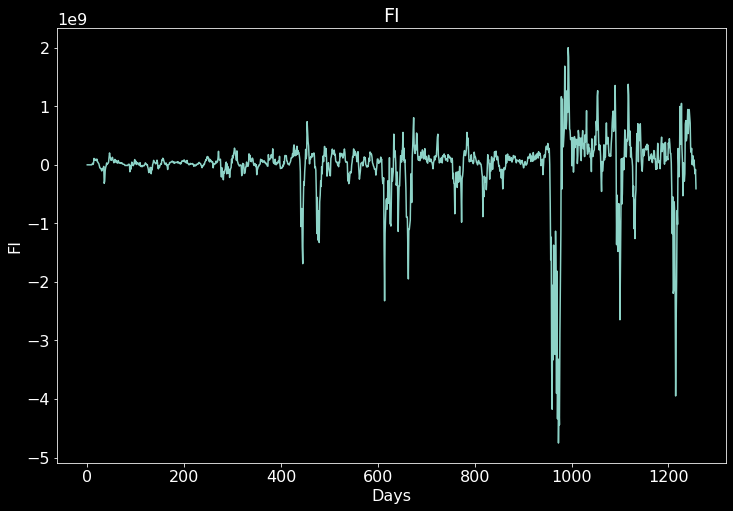

In [28]:

#plot_indicators(df, ['MACD_1'], "MACD", "Days")
#plot_indicators(df, ["EMA_10", "close"], "EMA", "Days")
#plot_indicators(df, "RSI_26", "RSI", "Days")
plot_indicators(df, "FI_10", "FI", "Days")

# Normalization and splitting of the Data

In [29]:
from sklearn.preprocessing import MinMaxScaler#, OneHotEncoder
from sklearn.model_selection import train_test_split
#from collections import Counter

pd.options.display.max_columns = 20

#print(df.columns)
#list_features = list(df.loc[:, 'open': 'OBV_'+str(indicator_range)].columns) # Gets the names of all the columns from MACD to RSI
list_features = list(df.loc[:, ~df.columns.isin(['timestamps', 'labels'])].columns)
print('Total number of features', len(list_features))
print("Columns:", list_features)


# df.loc[:, 'MACD':'RSI'].values: -> Data used to create 'x_train' and 'x_test'
# df['labels'].values: -> Data used to create 'y_train' and 'y_test'
#print(df.loc[:, 'MACD':'OBV'])
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'open': 'OBV_'+str(indicator_range)].values, df['labels'].values, train_size=0.8, test_size=0.2, random_state=2, shuffle=True, stratify=df['labels'].values)

if 0.7*x_train.shape[0] < 2500:
    # If training dataset is small, it increases the percentage of training
    train_split = 0.8
else:
    train_split = 0.7

print('train_split =', train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)

# Normalize the data in the range of [0, 1]
mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))


Total number of features 331
Columns: ['open', 'high', 'low', 'close', 'volume', 'MACD_1', 'MACD_2', 'MACD_3', 'MACD_4', 'MACD_5', 'MACD_6', 'MACD_7', 'MACD_8', 'MACD_9', 'MACD_10', 'MACD_11', 'MACD_12', 'MACD_13', 'MACD_14', 'MACD_15', 'MACD_16', 'MACD_17', 'MACD_18', 'MACD_19', 'MACD_20', 'MACD_21', 'MACD_22', 'MACD_23', 'MACD_24', 'MACD_25', 'MACD_26', 'RSI_6', 'RSI_7', 'RSI_8', 'RSI_9', 'RSI_10', 'RSI_11', 'RSI_12', 'RSI_13', 'RSI_14', 'RSI_15', 'RSI_16', 'RSI_17', 'RSI_18', 'RSI_19', 'RSI_20', 'RSI_21', 'RSI_22', 'RSI_23', 'RSI_24', 'RSI_25', 'RSI_26', '%D_1', '%D_2', '%D_3', '%D_4', '%D_5', '%D_6', '%D_7', '%D_8', '%D_9', '%D_10', '%D_11', '%D_12', '%D_13', '%D_14', '%D_15', '%D_16', '%D_17', '%D_18', '%D_19', '%D_20', '%D_21', '%D_22', '%D_23', '%D_24', '%D_25', '%D_26', 'WR_1', 'WR_2', 'WR_3', 'WR_4', 'WR_5', 'WR_6', 'WR_7', 'WR_8', 'WR_9', 'WR_10', 'WR_11', 'WR_12', 'WR_13', 'WR_14', 'WR_15', 'WR_16', 'WR_17', 'WR_18', 'WR_19', 'WR_20', 'WR_21', 'WR_22', 'WR_23', 'WR_24', 'WR_

# Feature Selection

*   SKLearn [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)

  *   Select features according to the k highest scores.

*   SKLearn [f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html)

  *   Computes the ANOVA F-value for the provided sample.

*   SKLearn [mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)

  *   Estimates mutual information for a discrete target variable.

*   Itemgetter [docs](https://docs.python.org/3/library/operator.html)


*3rd deviation from original paper*

In [30]:
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

num_features = 225  # should be a perfect square
selection_method = 'anova'
topk = 320 if selection_method == 'all' else num_features

if selection_method == 'anova' or selection_method == 'all':
    # Select features according to the k highest scores using f_classif
    select_k_best = SelectKBest(f_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_train, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_train, y_train)
    
    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(selected_features_anova)
    print(select_k_best.get_support(indices=True))
    print("****************************************")

if selection_method == 'mutual_info' or selection_method == 'all':
  # Select features according to the k highest scores using mutual_info_classif
    select_k_best = SelectKBest(mutual_info_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_train, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_train, y_train)

    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(len(selected_features_mic), selected_features_mic)
    print(select_k_best.get_support(indices=True))

if selection_method == 'all':
    # Chooses common features between anova and mutual_info if selection_method is set to 'all'
    common = list(set(selected_features_anova).intersection(selected_features_mic))
    print("common selected featues", len(common), common)
    if len(common) < num_features:
        raise Exception('number of common features found {} < {} required features. Increase "topk variable"'.format(len(common), num_features))
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:225])
    print(feat_idx)  # x_train[:, feat_idx] will give you training data with desired features

('volume', 'MACD_1', 'MACD_2', 'MACD_3', 'MACD_4', 'MACD_5', 'MACD_6', 'MACD_7', 'MACD_8', 'MACD_9', 'MACD_10', 'MACD_11', 'MACD_12', 'MACD_13', 'MACD_14', 'MACD_15', 'MACD_16', 'MACD_17', 'MACD_18', 'MACD_19', 'MACD_20', 'MACD_21', 'MACD_22', 'MACD_23', 'MACD_24', 'MACD_25', 'MACD_26', 'RSI_6', 'RSI_7', 'RSI_8', 'RSI_9', 'RSI_10', 'RSI_11', 'RSI_12', 'RSI_13', 'RSI_14', 'RSI_15', 'RSI_16', 'RSI_17', 'RSI_18', 'RSI_19', 'RSI_20', 'RSI_21', 'RSI_22', 'RSI_23', 'RSI_24', 'RSI_25', 'RSI_26', '%D_1', '%D_2', '%D_3', '%D_4', '%D_5', '%D_6', '%D_7', '%D_8', '%D_9', '%D_10', '%D_11', '%D_12', '%D_13', '%D_14', '%D_15', '%D_16', '%D_17', '%D_18', '%D_19', '%D_20', '%D_21', '%D_22', '%D_23', '%D_24', '%D_25', '%D_26', 'WR_1', 'WR_2', 'WR_3', 'WR_4', 'WR_5', 'WR_6', 'WR_7', 'WR_8', 'WR_9', 'WR_10', 'WR_11', 'WR_12', 'WR_13', 'WR_14', 'WR_15', 'WR_16', 'WR_17', 'WR_18', 'WR_19', 'WR_20', 'WR_21', 'WR_22', 'WR_23', 'WR_24', 'WR_25', 'WR_26', 'EMA_1', 'MFI_2', 'MFI_3', 'MFI_4', 'MFI_5', 'MFI_6', 'M

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


# Method: *reshape_as_image*

In [31]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

# Reshaping the Data of 225 technical indicators into images

In [32]:
dim = int(np.sqrt(num_features)) # Computing dimension of image --> 15
x_train = reshape_as_image(x_train, dim, dim) # Reshape x_train into 15x15 image
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
# # Reshape y_train to N x 1
# y_train = y_train.reshape((len(y_train), 1))
# # Reshape y_test to N x 1
# y_test = y_test.reshape((len(y_test), 1))
# # Reshape y_test to N x 1
# y_cv = y_cv.reshape((len(y_cv), 1))
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))
print("x_cv shape:", x_cv.shape)

final shape of x, y train/test (804, 15, 15, 3) (804,) (252, 15, 15, 3) (252,)
x_cv shape: (202, 15, 15, 3)


# Displays 9 random images within *x_train*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


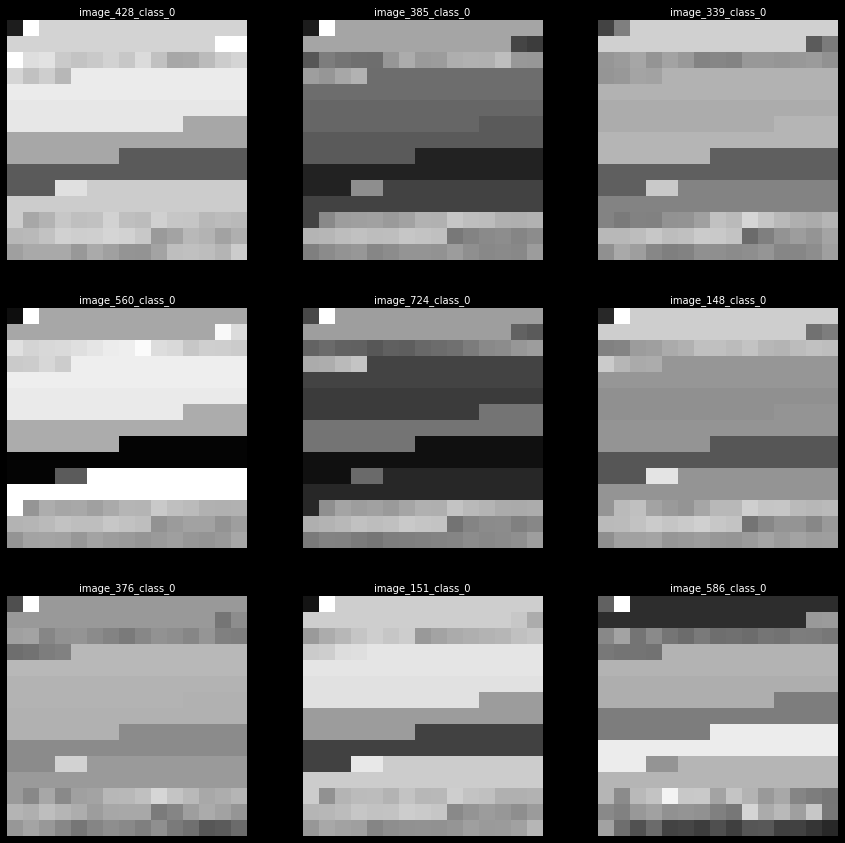

In [33]:
fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.show()

# Current Class Imbalance

Sell = 0, Buy = 1, Hold = 2

In [34]:
class_labels, class_count = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {:.3f}%, class 1 = {:.3f}%, class 2 = {:.3f}%".format(class_count[0]/len(y_train)*100, class_count[1]/len(y_train)*100, class_count[2]/len(y_train)*100))

percentage of class 0 = 6.841%, class 1 = 5.473%, class 2 = 87.687%


In [35]:
print(x_train[0].shape[0])
print(x_train[0].shape[1])
print(x_train[0].shape[2])
print(x_train.shape)

15
15
3
(804, 15, 15, 3)


# Construct Train, Validation, and Test datasets

In [36]:
# from tensorflow.data import Dataset

# # Train tensorflow datasets
# train_image_ds = Dataset.from_tensor_slices(x_train)
# train_label_ds = Dataset.from_tensor_slices(y_train)
# train_sample_weights_ds = Dataset.from_tensor_slices(sample_weights)
# # Combined image and label training dataset
# train_ds = Dataset.zip((train_image_ds, train_label_ds))

# # Test tensorflow datasets
# test_image_ds = Dataset.from_tensor_slices(x_test)
# test_label_ds = Dataset.from_tensor_slices(y_test)
# # Combined image and label testing dataset
# test_ds = Dataset.zip((test_image_ds, test_label_ds))

# # Validation tensorflow datasets
# val_image_ds = Dataset.from_tensor_slices(x_cv)
# val_label_ds = Dataset.from_tensor_slices(y_cv)
# # Combined image and label validation dataset
# val_ds = Dataset.zip((val_image_ds, val_label_ds))

# for image, label in train_ds.take(1):
#     print(image.shape)
#     print(label.shape)

# One Hot encoding

In [37]:
# def one_hot(image, label):
#     label = tf.cast(label, tf.int32)
#     return image, tf.one_hot(label[0], 3)

# train_ds = train_ds.map(one_hot)

# for image, label in train_ds.take(1):
#     print(image.shape)
#     print(label.shape)

# Building Convolutional Neural Network

In [38]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers

model = Sequential([
    Conv2D(filters=32, 
           kernel_size=3, 
           strides=1, 
           kernel_regularizer=regularizers.l2(0.0), 
           padding='same', 
           activation='relu', 
           use_bias=True,
           kernel_initializer='glorot_uniform',
           input_shape=(x_train[0].shape[0], x_train[0].shape[1], x_train[0].shape[2])),
    Dropout(rate=0.2),
    Conv2D(filters=64, 
           kernel_size=3, 
           strides=2, 
           kernel_regularizer=regularizers.l2(0.0), 
           padding='same', 
           activation='relu', 
           use_bias=True, 
           kernel_initializer='glorot_uniform'),
    MaxPool2D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(units=128, 
          activation='relu'),
    Dropout(rate=0.3),
    Dense(units=3, activation='softmax')
])

# F1 Metric Definition

<font color='red'>TODO: Complete documentation of function</font>

In [39]:
from tensorflow.keras import backend as K

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall 
    """

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # mistake: y_pred of 0.3 is also considered 1
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    # y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    # y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    # conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    # tf.Print(conf_mat, [conf_mat], "confusion_matrix")

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Choosing 'Sample Weights' for the model to pay more attention to

In [40]:
from sklearn.utils.class_weight import compute_class_weight

def get_sample_weights(y):
        """
        calculate the sample weights based on class weights. Used for models with
        imbalanced data and one hot encoding prediction.
        params:
            y: class labels as integers
        """

        y = y.astype(int)  # compute_class_weight needs int labels
        class_weights = compute_class_weight('balanced', np.unique(y), y)

        print("real class weights are {}".format(class_weights), np.unique(y))
        print("value_counts", np.unique(y, return_counts=True))
        sample_weights = y.copy().astype(float)
        for i in np.unique(y):
            sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

        return sample_weights

sample_weights = get_sample_weights(y_train)
print("Test sample_weights")
rand_idx = np.random.randint(0, len(y_train), 30)
print(y_train[rand_idx])
print(sample_weights[rand_idx])
print(sample_weights.shape)

real class weights are [4.87272727 6.09090909 0.38014184] [0 1 2]
value_counts (array([0, 1, 2]), array([ 55,  44, 705]))
Test sample_weights
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2.
 2. 2. 2. 2. 2. 2.]
[0.38014184 0.38014184 0.38014184 0.38014184 0.38014184 0.38014184
 0.38014184 0.38014184 0.38014184 0.38014184 0.38014184 0.38014184
 0.38014184 0.38014184 0.38014184 0.38014184 0.38014184 0.38014184
 0.38014184 0.38014184 0.38014184 4.87272727 0.38014184 0.38014184
 0.38014184 0.38014184 0.38014184 0.38014184 0.38014184 0.38014184]
(804,)


# Compiling Model



*   *Optimizer:* Adam
*   *Loss:* Sparse Categorical Crossentropy

<font color="red"> TODO: Sparse Categorical Crossentropy vs Categorical_Entropy </font>



In [41]:
from tensorflow.keras import optimizers

optimizer_model = 'adam'
learning_rate = 0.001

if optimizer_model == 'rmsprop':
    optimizer = optimizers.RMSprop(lr=learning_rate)
elif optimizer_model == 'sgd':
    optimizer = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
elif optimizer_model == 'adam':
    optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='SparseCategoricalCrossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])

# Model Callbacks

<font color='lightgreen'>**EarlyStropping**</font>

*   <font color='orange'>monitor</font>: Quantity to be monitored
*   <font color='orange'>mode</font>: 
  *   `min`: training will stop when the quantity monitored has stopped decreasing
  *   `max`: training will stop when the quantity monitored has stopped increasing
  *   `auto`: the direction is automatically inferred from the name of the monitored quantity
*   <font color='orange'>verbose</font>:
  *   `verbose=0` will show you nothing (silent)
  *   `verbose=1` will show you an animated progress bar
  *   `verbose=2` will just mention the number of epoch
*   <font color='orange'>patience</font>: Number of epochs with no improvement after which training will be stopped.
*   <font color='orange'>min_delta</font>: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

A `model.fit()` training loop will check at end of every epoch whether the loss is no longer decreasing, considering the `min_delta` and `patience` if applicable


---

<font color='lightgreen'>**ReduceLROnPlateau**</font>

> Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

*   <font color='orange'>monitor</font>: quantity to be monitored
*   <font color='orange'>factor</font>: factor by which the learning rate will be reduced. `new_lr = lr * factor`
*   <font color='orange'>patience</font>: number of epochs with no improvement after which learning rate will be reduced
*   <font color='orange'>verbose</font>:
  *   `verbose=0` will show you nothing (silent)
  *   `verbose=1` will show you an animated progress bar
  *   `verbose=2` will just mention the number of epoch
*   <font color='orange'>mode</font>:
  *   `min`: training will stop when the quantity monitored has stopped decreasing
  *   `max`: training will stop when the quantity monitored has stopped increasing
  *   `auto`: the direction is automatically inferred from the name of the monitored quantity
*   <font color='orange'>min_delta</font>: threshold for measuring the new optimum, to only focus on significant changes
*   <font color='orange'>cooldown</font>: number of epochs to wait before resuming normal operation after lr has been reduced
*   <font color='orange'>min_lr</font>: lower bound on the learning rate


---

<font color='lightgreen'>**ModelCheckpoint**</font>

> `ModelCheckpoint` callback is used in conjunction with training using `model.fit()` to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

A few options this callback provides include:
  * Whether to only keep the model that has achieved the "best performance" so far, or whether to save the model at the end of every epoch regardless of performance.
  * Definition of 'best'; which quantity to monitor and whether it should be maximized or minimized.
  * The frequency it should save at. Currently, the callback supports saving at the end of every epoch, or after a fixed number of training batches.
  * Whether only weights are saved, or the whole model is saved.

*   <font color='orange'>filepath</font>: 
  * string or `PathLike`, path to save the model file. `filepath` can contain named formatting options, which will be filled the value of `epoch` and keys in `logs` (passed in on_epoch_end). For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`, then the model checkpoints will be saved with the epoch number and the validation loss in the filename.
*   <font color='orange'>monitor</font>: quantity to be monitored
  * Prefix the name with `val_` to monitor validation metrics.
  * Use `loss` or `val_loss` to monitor the model's total loss.
  * If you specify metrics as strings, like `accuracy`, pass the same string (with or without the "val_" prefix).
  * If you pass `metrics.Metric` objects, monitor should be set to `metric.name`
  * If you're not sure about the metric names you can check the contents of the `history.history` dictionary returned by `history = model.fit()`
  * Multi-output models set additional prefixes on the metric names.
*   <font color='orange'>verbose</font>: verbosity mode, 0 or 1.
*   <font color='orange'>save_best_only</font>: 
  * if `save_best_only=True`, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. If `filepath` doesn't contain formatting options like `{epoch}` then `filepath` will be overwritten by each new better model.
*   <font color='orange'>save_weights_only</font>: 
  * if True, then only the model's weights will be saved `(model.save_weights(filepath))`, else the full model is saved `(model.save(filepath))`.
*   <font color='orange'>mode</font>: 
  *   `min`: training will stop when the quantity monitored has stopped decreasing
  *   `max`: training will stop when the quantity monitored has stopped increasing
  *   `auto`: the direction is automatically inferred from the name of the monitored quantity
*   <font color='orange'>save_freq</font>:
  * `'epoch'` or integer. When using `'epoch'`, the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches. If the `Model` is compiled with `steps_per_execution=N`, then the saving criteria will be checked every Nth batch. Note that if the saving isn't aligned to epochs, the monitored metric may potentially be less reliable (it could reflect as little as 1 batch, since the metrics get reset every epoch). Defaults to `'epoch'`


[Docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
import os

best_model_path = os.path.join('.', 'best_model_keras')

es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=100, 
    min_delta=0.0001
    )

rlp = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.02, 
    patience=20, 
    verbose=1, 
    mode='min', 
    min_delta=0.001, 
    cooldown=1, 
    min_lr=0.001
    )

mcp = ModelCheckpoint(
    best_model_path, 
    monitor='val_f1_metric', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='max', 
    save_freq=1
    )

# Training model

In [43]:
%%time

history = model.fit(
    x_train,
    y_train, 
    epochs=30, 
    verbose=1, 
    batch_size=64, 
    shuffle=True, 
    validation_data=(x_cv, y_cv), 
    callbacks=[mcp, rlp, es], 
    sample_weight=sample_weights
    )

# history = model.fit(
#     x_train, 
#     y_train, 
#     epochs=30, 
#     verbose=1, 
#     batch_size=64, 
#     shuffle=True, 
#     validation_data=(x_cv, y_cv), 
#     callbacks=[mcp, rlp, es], 
#     sample_weight=sample_weights
#     )

Epoch 1/30
13/13 [==============================] - 34s 57ms/step - loss: 1.0777 - accuracy: 0.4893 - f1_metric: 4.3815 - val_loss: 1.1342 - val_accuracy: 0.1139 - val_f1_metric: 5.5975
Epoch 2/30
13/13 [==============================] - 0s 13ms/step - loss: 1.0409 - accuracy: 0.3574 - f1_metric: 5.1471 - val_loss: 0.9762 - val_accuracy: 0.2871 - val_f1_metric: 4.1702
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 1.0070 - accuracy: 0.4012 - f1_metric: 3.0418 - val_loss: 0.8987 - val_accuracy: 0.5842 - val_f1_metric: 2.3419
Epoch 4/30
13/13 [==============================] - 0s 12ms/step - loss: 0.7262 - accuracy: 0.5716 - f1_metric: 2.1279 - val_loss: 0.8381 - val_accuracy: 0.6485 - val_f1_metric: 1.6419
Epoch 5/30
13/13 [==============================] - 0s 13ms/step - loss: 0.6835 - accuracy: 0.6238 - f1_metric: 1.6869 - val_loss: 0.6387 - val_accuracy: 0.7228 - val_f1_metric: 1.5734
Epoch 6/30
13/13 [==============================] - 0s 14ms/step - loss: 0

In [44]:
y_pred = model.predict(x_test)
y_pred.shape

(252, 3)

# Implementation of trading algorithm

*   Assume all currency is in USD
*   Assume trading in fractional shares in not restricted
*   Assume that there are no broker trading fees



In [74]:
model_variation = []
price_variation = []
share_hist = []
cash_hist = []

maximum_trade_size = 3000.00
cash_on_hand = 10000.00
initial_value = cash_on_hand
number_of_shares = 0.00
accuracy = 0

for i, pred_arr in enumerate(y_pred):
    max_index = np.argmax(pred_arr)
    current_price = df.iloc[-y_pred.shape[0]-1+i]['close']
    previous_price = df.iloc[-y_pred.shape[0]-2+i]['close']
    if (max_index == 0):
        # Determining how many share to sell
        shares_to_sell = min(round((maximum_trade_size * pred_arr[max_index]) / previous_price, 4), number_of_shares)
        if ((number_of_shares - shares_to_sell) < 10):
            shares_to_sell = 0
        number_of_shares = number_of_shares - shares_to_sell
        cash_on_hand = cash_on_hand + (shares_to_sell * previous_price)
    elif (max_index == 1):
        # Determining how many share to buy
        maximum_allow_trade_size = min(maximum_trade_size, cash_on_hand)
        shares_to_buy = round((maximum_allow_trade_size * pred_arr[max_index]) / previous_price, 4)
        number_of_shares = number_of_shares + shares_to_buy
        cash_on_hand = cash_on_hand - (shares_to_buy * previous_price)
    # else:
    #     print("Hold")
    #print(5.00 * pred_arr[max_index])

    starting_price = df.iloc[-y_pred.shape[0]-1]['close']
    #print('starting_price:', starting_price)
    #print(df.iloc[-y_pred.shape[0]-1]['close'])

    price_variation.append((current_price-starting_price) / starting_price * 100)

    model_variation.append((cash_on_hand + (number_of_shares * current_price) - initial_value) / initial_value * 100)

    share_hist.append(number_of_shares)

    cash_hist.append(cash_on_hand)

    actual_label = df.iloc[len(df.index)-y_pred.shape[0]-1+i]['labels']

    if (max_index == actual_label):
        accuracy = accuracy + 1

end_price = df.iloc[len(df.index)-1]['close']
share_value = end_price * number_of_shares

model_variation = np.array(model_variation)   # Transformed into a numpy array
price_variation = np.array(price_variation)   # Transformed into a numpy array

print("Model accuracy: {:.3f}%".format(accuracy / (y_pred.shape[0]) * 100))

print("Cash left on hand: {:.3f}\nNumber of shares: {:.3f}\nValue of shares: {:.3f}\nTotal Value: {:.3f}".format(cash_on_hand, number_of_shares, share_value, cash_on_hand + share_value))

Model accuracy: 75.000%
Cash left on hand: 3027.503
Number of shares: 26.391
Value of shares: 8712.560
Total Value: 11740.063


# Visualizing Model Performance vs. Stock Price Change

Text(0.5, 1.0, 'Model vs. Stock % Change Comparison')

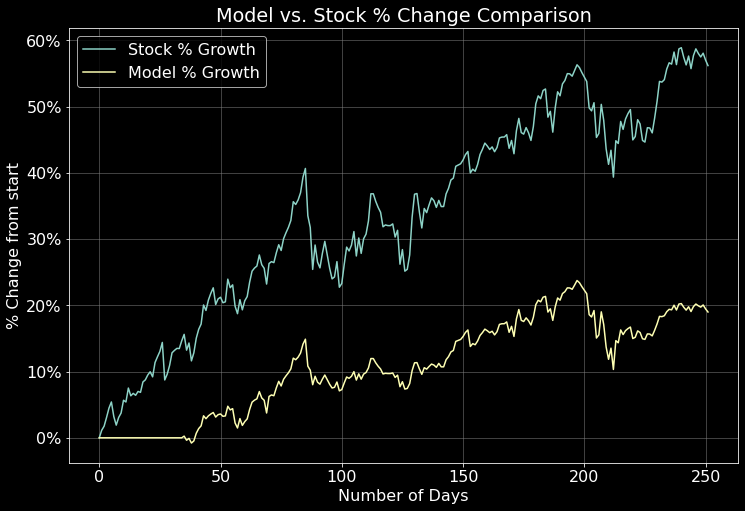

In [75]:
import matplotlib.ticker as mtick

fig, (ax) = plt.subplots(1, 1, sharex=True)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

ax.plot(price_variation, label='Stock % Growth')
ax.plot(model_variation, label='Model % Growth')

ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

ax.legend(loc='upper left')

ax.set_ylabel('% Change from start')
ax.set_xlabel('Number of Days')
ax.set_title('Model vs. Stock % Change Comparison')


# Method for ploting confusion matrix of Predicted and Actual labels

In [76]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

# Plots confusion matrix of Actual and Predicted Buy/Sell/Hold labels

Predicted   0   1    2  All
Actual                     
0.0         0   3   21   24
1.0         0   2   13   15
2.0        17   9  187  213
All        17  14  221  252


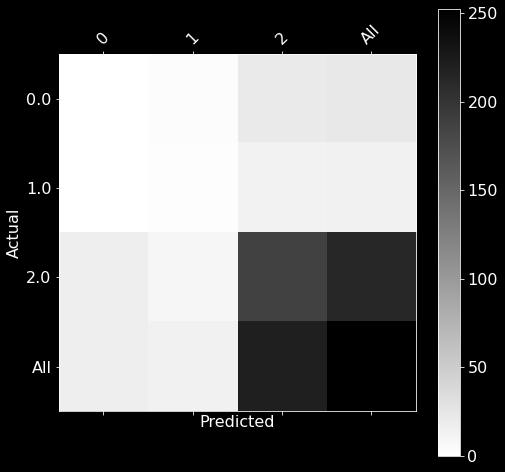

In [77]:
from sklearn.metrics import confusion_matrix
# Gets the index of each row with the highest prediction
pred_labels = np.argmax(y_pred, axis=1)
pred_labels = pd.Series(pred_labels, name='Predicted')
# Gets the actual label of the test data
actual_labels = df.iloc[-y_pred.shape[0]-1: -1]['labels'].to_numpy()
actual_labels = pd.Series(actual_labels, name='Actual')

df_confusion = pd.crosstab(actual_labels, pred_labels, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)
plot_confusion_matrix(df_confusion)

# Method for visualizing marker placement on price and model value variation

*SELL = 0, BUY = 1, HOLD = 2*

In [91]:
import matplotlib.ticker as mtick

def marker_visualization(actual_markers, predicted_markers, title):
    fig, (ax) = plt.subplots(1, 1, sharex=True)

    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)

    ax.plot(price_variation, 
            label='Stock % Growth', 
            color='lightgreen',
            markevery=actual_markers, 
            marker='o', 
            markerfacecolor='white', 
            markeredgecolor='blue', 
            markersize=7.5)
    ax.plot(model_variation, 
            label='Model % Growth', 
            color='orange',
            markevery=predicted_markers, 
            marker='^', 
            markerfacecolor='white',
            markeredgecolor='red', 
            markersize=7.5)

    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    ax.legend(loc='upper left')

    ax.set_ylabel('% Change from start')
    ax.set_xlabel('Number of Days')
    ax.set_title(title)

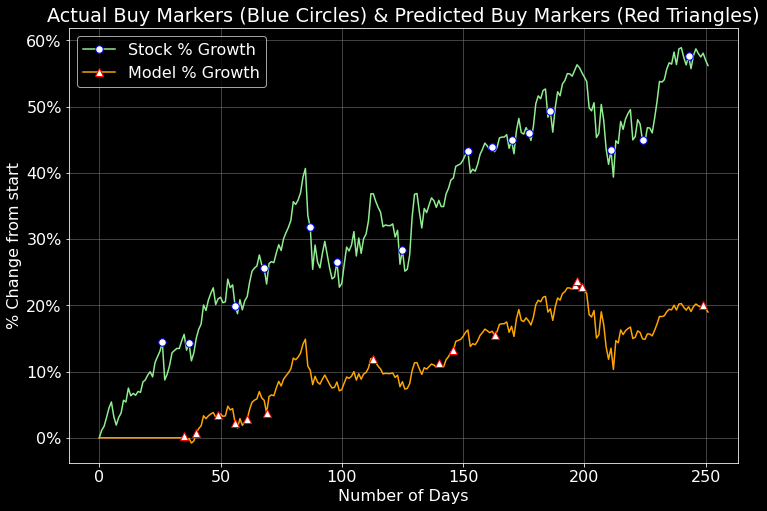

In [93]:
predicted_buy_markers = np.where(pred_labels == 1)
predicted_buy_markers = list(np.array(predicted_buy_markers)[0])
actual_buy_markers = list(np.where(df[-pred_labels.shape[0]:]['labels'] == 1)[0])

marker_visualization(actual_markers=actual_buy_markers, predicted_markers=predicted_buy_markers, title='Actual Buy Markers (Blue Circles) & Predicted Buy Markers (Red Triangles)')

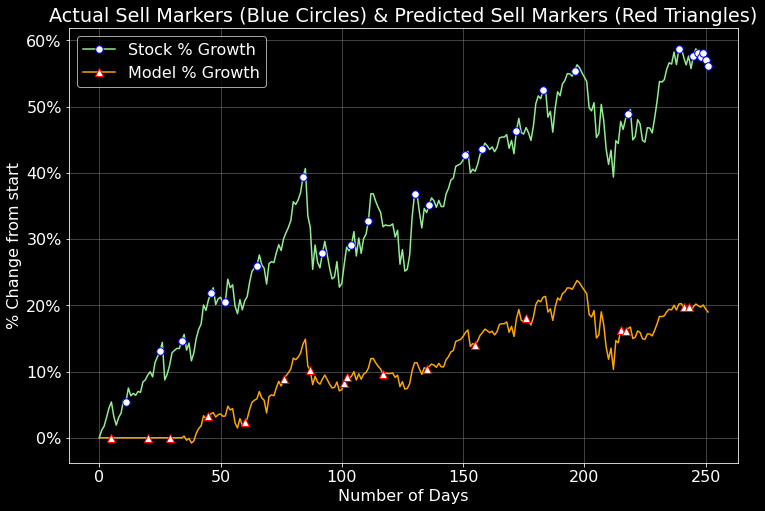

In [94]:
predicted_sell_markers = np.where(pred_labels == 0)
predicted_sell_markers = list(np.array(predicted_sell_markers)[0])
actual_sell_markers = list(np.where(df[-pred_labels.shape[0]:]['labels'] == 0)[0])


marker_visualization(actual_markers=actual_sell_markers, predicted_markers=predicted_sell_markers, title='Actual Sell Markers (Blue Circles) & Predicted Sell Markers (Red Triangles)')

# Visualizing the number of shares over the course of the trading cycle

Text(0, 0.5, 'Number of Shares')

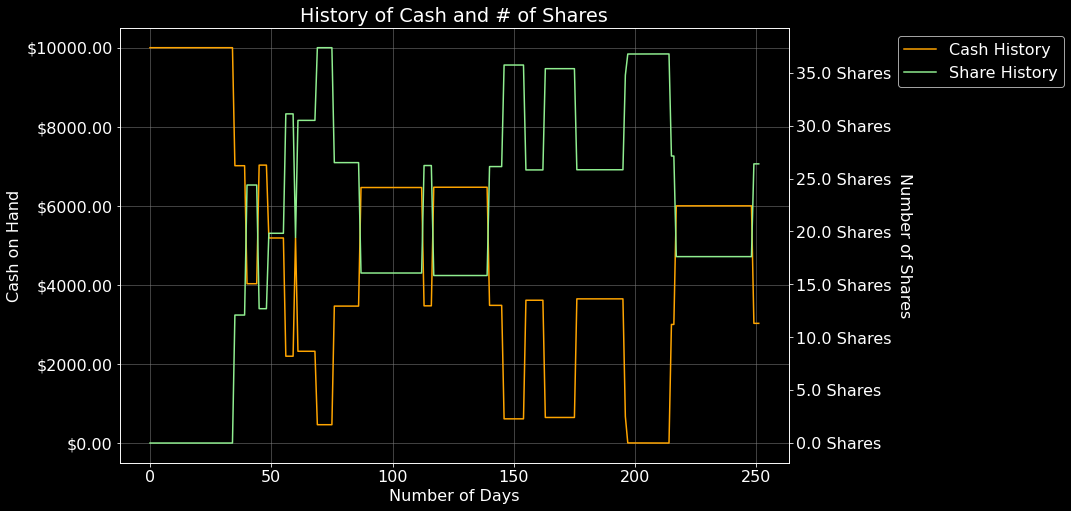

In [81]:
fig, (ax) = plt.subplots(1, 1, sharex=True)

line_1 = ax.plot(cash_hist, color='orange', label='Cash History')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

ax2 = ax.twinx()      # Add a secondary axis
line_2 = ax2.plot(share_hist, color='lightgreen', label='Share History')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:1.1f} Shares'.format(x) for x in vals])

lns = line_1 + line_2
labs = [l.get_label() for l in lns]

ax.legend(lns, labs, bbox_to_anchor=(1.15, 1), loc='upper left')
ax.set_title('History of Cash and # of Shares')
ax.set_ylabel('Cash on Hand')
ax.set_xlabel('Number of Days')
ax2.set_ylabel('Number of Shares', rotation=-90, labelpad=20)

# Method for visualizing marker placement

In [69]:
def marker_visualization(df, markers, title):
    ax = df.plot(
        x='timestamps', 
        y=['close'], 
        kind='line', 
        color='lightgreen', 
        title=title, 
        markevery=markers, 
        marker='o', 
        markerfacecolor='white')
    vals = ax.get_yticks()
    ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    plt.show()

# Model predicted SELL when the actual label was HOLD

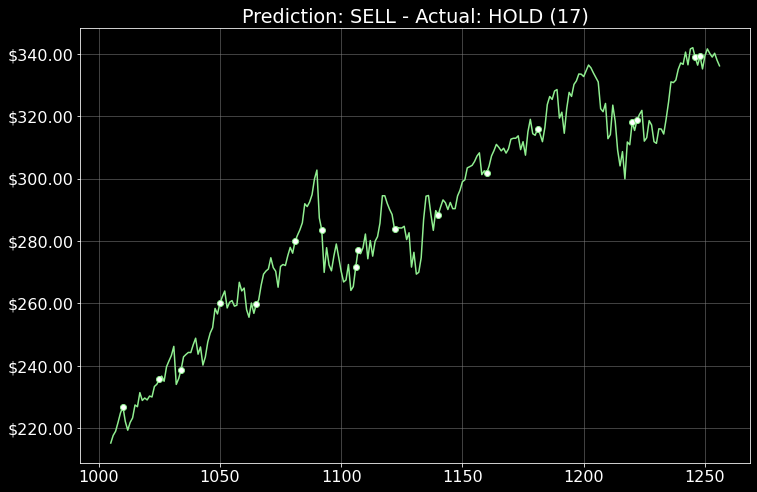

In [70]:
pred_action = np.where(pred_labels == 0)
actual_action = np.where(actual_labels == 2)
label_markers = list(np.intersect1d(pred_action, actual_action))

close_df = df.iloc[-y_pred.shape[0]-1: -1]['close']
marker_visualization(close_df, label_markers, 'Prediction: SELL - Actual: HOLD (' + str(len(label_markers)) + ')')

# Model predicted BUY when the actual label was HOLD

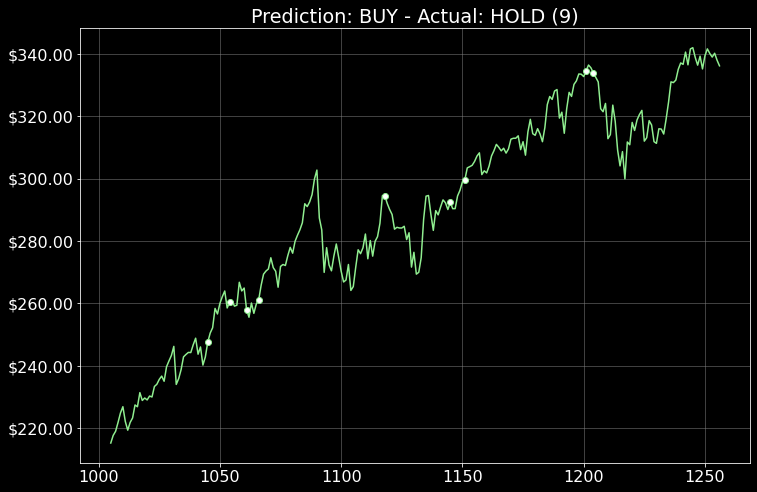

In [71]:
pred_sell = np.where(pred_labels == 1)
actual_hold = np.where(actual_labels == 2)
label_markers = list(np.intersect1d(pred_sell, actual_hold))

close_df = df.iloc[-y_pred.shape[0]-1: -1]['close']

marker_visualization(close_df, label_markers, 'Prediction: BUY - Actual: HOLD (' + str(len(label_markers)) + ')')

# Model predicted HOLD when the actual label was SELL

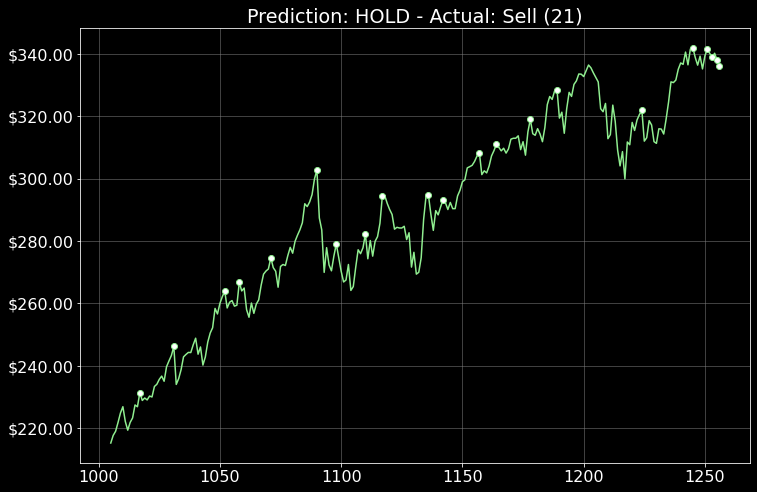

In [72]:
pred_action = np.where(pred_labels == 2)
actual_action = np.where(actual_labels == 0)
label_markers = list(np.intersect1d(pred_action, actual_action))

close_df = df.iloc[-y_pred.shape[0]-1: -1]['close']

marker_visualization(close_df, label_markers, 'Prediction: HOLD - Actual: Sell (' + str(len(label_markers)) + ')')

# Model predicted HOLD when the actual label was BUY

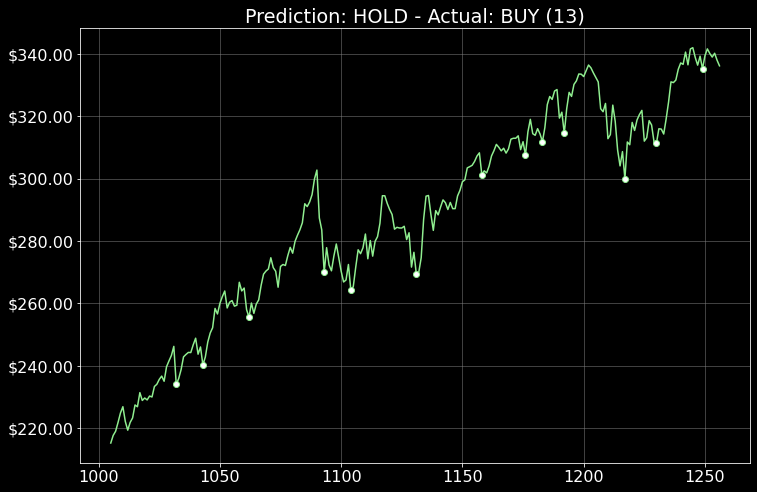

In [73]:
pred_action = np.where(pred_labels == 2)
actual_action = np.where(actual_labels == 1)
label_markers = list(np.intersect1d(pred_action, actual_action))

close_df = df.iloc[-y_pred.shape[0]-1: -1]['close']

marker_visualization(close_df, label_markers, 'Prediction: HOLD - Actual: BUY (' + str(len(label_markers)) + ')')

In [58]:
#eval = model.evaluate(x=x_test, y=y_test, batch_size=64, verbose=1)